In [1]:
import numpy as np
import argparse
import cv2
import os
import time

In [11]:
def predict(net, layer_names, labels, image, confidence, threshold):
    height, width = image.shape[:2]
    
    # Create a blob and pass it through the model
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)

    # Extract bounding boxes, confidences and classIDs
    boxes, confidences, classIDs = box_attribute_identification(outputs, confidence, width, height)

    # Apply Non-Max Suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    return boxes, confidences, classIDs, idxs

In [12]:
def box_attribute_identification(outputs, confidence, width, height):
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:            
            # Extract the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classID = np.argmax(scores)
            conf = scores[classID]
            
            # Consider only the predictions that are above the confidence threshold
            if conf > confidence:
                # Scale the bounding box back to the size of the image
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, w, h = box.astype('int')

                # Use the center coordinates, width and height to get the coordinates of the top left corner
                x = int(centerX - (w / 2))
                y = int(centerY - (h / 2))

                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(conf))
                classIDs.append(classID)

    return boxes, confidences, classIDs

In [13]:
def bounding_box_mapping(image, boxes, confidences, classIDs, idxs, colors):
    if len(idxs) > 0:
        for i in idxs.flatten():
            # extract bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # draw the bounding box and label on the image
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

In [14]:
#python3 yolo.py -w model/yolov3.weights -cfg model/yolov3.cfg -l model/coco.names -i image1.jpg -s
weights='model/yolov3.weights'
config='model/yolov3.cfg'
labels='model/coco.names'
image_path='/Users/krisk/Downloads/petfinder-adoption-prediction/train_images/b30bcaab6-1.jpg'
confidence=0.5
threshold=0.3
use_gpu=False
save=False
show=True


In [15]:
# Get the labels
labels = open(labels).read().strip().split('\n')

# Create a list of colors for the labels
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Load weights using OpenCV
net = cv2.dnn.readNetFromDarknet(config, weights)

In [16]:
layer_names = net.getLayerNames()
layer_names = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]

image = cv2.imread(image_path)

boxes, confidences, classIDs, idxs = predict(net, layer_names, labels, image, confidence, threshold)

In [17]:
print(idxs)
print(labels[classIDs[0]])
print("X:",boxes[0][0],"Y:",boxes[0][1],"ImgWidth:",boxes[0][2],"ImgHeight:",boxes[0][3])
print('Width:',image.shape[1])
print('Height:',image.shape[0])
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread


[13  3  6 15 17]
dog
X: 25 Y: 2 ImgWidth: 204 ImgHeight: 281
Width: 640
Height: 640


In [18]:

image = bounding_box_mapping(image, boxes, confidences, classIDs, idxs, colors)


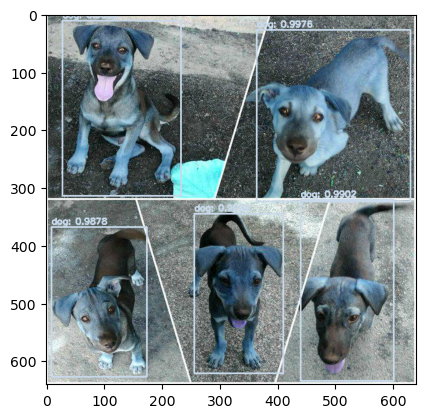

In [19]:
pyplot.imshow(image)